# **FINE TUNING WITH LAST LAYER UNFREEZED AND AUGUMENTATION**

In this paper we are going to perform the fine tuning by unfreezing the last layer of our network and the applying the data augumentation to our features.

## **Mount and unzipping**

At the beginning we allow the access to our Google Drive and then we unzip the dataset on our folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/progetto/dbs -all

total 16
drwx------ 2 root root 4096 Feb  7 21:28  dataset
drwx------ 2 root root 4096 Feb  6 16:30  facial_expression
drwx------ 2 root root 4096 Feb  5 22:16 'total_dbs(all images training one directory)'
drwx------ 2 root root 4096 Feb  5 22:12 'total_dbs_testing(all images public testing one directory)'


In [ ]:
pip install keras-facenet

In [ ]:
'''
# Unzipping dataset
%cd '/content/gdrive/MyDrive/progetto/dbs/' 
!unzip -q original_facial_expression.zip
'''

"\n# Unzipping dataset\n%cd '/content/gdrive/MyDrive/progetto/dbs/' \n!unzip -q original_facial_expression.zip\n"

Now we import all the needed modules and we define the folders' path that we are going to use.

In [ ]:
import glob
import os
import numpy as np
import PIL
from PIL import ImageDraw, ImageOps, Image

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from keras.models import load_model


from IPython.display import display
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

np.random.seed(42)
tf.random.set_seed(42)


BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/facial_expression/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')





BATCH_SIZE = 32

## **Dataset Loading** 

We use *image_dataset_from_directory()* provided by Keras to load the image dataset. At the end we perform the *prefetch()* function to improve the performance in dataset loading. Thanks to *prefectch()*, while model is executing the step *s* of the training, input pipeline read data for the step *s+1*. In this way the time needed is `max(training_time, time_to_read_data)` instead of `training_time + time_to_read_data`. 

In [ ]:


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   TRAIN_DATA_DIR,
   subset="validation",
   shuffle=False,
   validation_split=0.2,
   seed=123,
   image_size=(160, 160),
   batch_size=BATCH_SIZE,
   color_mode='rgb')

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=123,
    shuffle=False,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')


train_dataset = train_dataset.prefetch(buffer_size=BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=BATCH_SIZE)
testing_dataset = testing_dataset.prefetch(buffer_size=BATCH_SIZE)




Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 3589 files belonging to 7 classes.


## **Training**

Before to train our network, since our pretrained network doesn't belong to Keras, we are going to load the Inception ResNet v1 loading the weights and the model of the facenet keras respectively.


On the top of the pretrained network, we build our densly connected network. Before to add a *Flatten layer* that reshape the pretrained network's we do the data augumentation with two functions *RandomFlip* that randomly flips each image of the dataset horizontally and *RotationFlip* that randomly rotates each image of the dataset. Then, we have two *Dense layers*: the first has 64 hidden layers with **ReLu** activation function while the last one has 7 layers (as the output class we have) with **softmax** activation function. Since we don't want to perform fine-tuning, hence we don't want to recompute the weights of the pretrained network, then we set the layer`trainable = False`.

In [ ]:


weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/weights/facenet_keras_weights.h5'
top_model_weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5'

facenet = load_model(top_model_weights_path)
facenet.load_weights(weights_path)


for layer in facenet.layers:

    layer.trainable = False

model= Sequential()




model.add(L.Input(shape=(160,160,3)))
#data augumentation
model.add(L.experimental.preprocessing.RandomFlip(mode = 'horizontal', seed = 123))
model.add(L.experimental.preprocessing.RandomRotation(factor=0.2, seed=123, fill_mode='nearest'))

model.add(facenet)
model.add(L.Flatten())



model.add(L.Dense(64, activation='relu',name = 'classifier_hidden'))
model.add(L.Dense(7,activation = 'softmax'))


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 22,816,855
Trainable params: 8,711
Non-trainable params: 22,808,144
________________________________________

Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. As optimizer, we use **RMSprop** with a very low **learning rate**. To avoid the problem of overfitting, we add also the **early stopping** whereby the training will stop when the chosen performance measure stops improving. To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])



callbacks = [
    # early stopping
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),

    # model checkpoints (save the best model)
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        filepath='/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_augumented.h5'),
]

history = model.fit(
      train_dataset,
      epochs=50,
      verbose=1,
      callbacks=callbacks,
      validation_data=valid_dataset,
      batch_size=BATCH_SIZE)

Epoch 1/50
718/718 [==============================] - 61s 74ms/step - loss: 2.6819 - accuracy: 0.1437 - val_loss: 2.2285 - val_accuracy: 0.0934
Epoch 2/50
718/718 [==============================] - 53s 73ms/step - loss: 1.9251 - accuracy: 0.2022 - val_loss: 2.0368 - val_accuracy: 0.0746
Epoch 3/50
718/718 [==============================] - 52s 73ms/step - loss: 1.8861 - accuracy: 0.2123 - val_loss: 1.9908 - val_accuracy: 0.0700
Epoch 4/50
718/718 [==============================] - 54s 74ms/step - loss: 1.8709 - accuracy: 0.2167 - val_loss: 1.9754 - val_accuracy: 0.0622
Epoch 5/50
718/718 [==============================] - 53s 73ms/step - loss: 1.8616 - accuracy: 0.2186 - val_loss: 1.9683 - val_accuracy: 0.0625
Epoch 6/50
718/718 [==============================] - 51s 71ms/step - loss: 1.8523 - accuracy: 0.2231 - val_loss: 1.9651 - val_accuracy: 0.0627
Epoch 7/50
718/718 [==============================] - 52s 72ms/step - loss: 1.8434 - accuracy: 0.2248 - val_loss: 1.9565 - val_accuracy:

# **Plot**

Now we plot the results obtained.

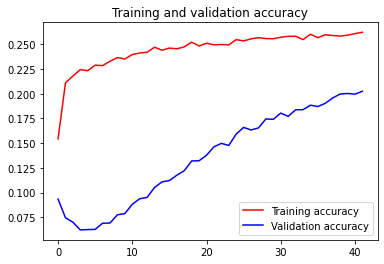

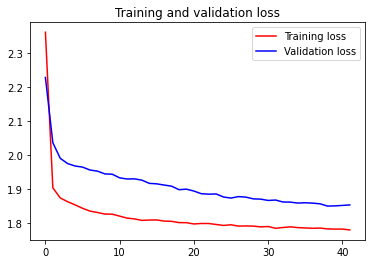

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Finetune the pretrained network**

We can try to improve these results by performing fine tuning. In particular, in this paper we try to fine tune the last layer of the pretrained network by setting the layer 'Block8_6_Branch_1_Conv2d_0a_1x1' `trainable = True` 
Our densly connected network builds on the top of the pretrained network is the same we have seen before.

In [ ]:
#try to un-freeze the last block

facenet.trainable = True


set_trainable = False
for layer in facenet.layers:
    if layer.name == 'Block8_6_Branch_1_Conv2d_0a_1x1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Since we have many classes and an image belongs only to a specific class, we use the sparse categorical crossentropy as loss function. We use as optimizer **RMSprop** with a **learning rate** of magnitude same as before and we use again the early stoppinh technique to avoid the overfitting seen previously.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
fine_history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=valid_dataset,
      callbacks = callbacks,
      batch_size = BATCH_SIZE
      )

Epoch 1/100
718/718 [==============================] - 61s 77ms/step - loss: 2.0178 - accuracy: 0.2407 - val_loss: 1.7906 - val_accuracy: 0.2695
Epoch 2/100
718/718 [==============================] - 55s 76ms/step - loss: 1.8632 - accuracy: 0.2494 - val_loss: 1.7936 - val_accuracy: 0.2783
Epoch 3/100
718/718 [==============================] - 55s 75ms/step - loss: 1.8100 - accuracy: 0.2679 - val_loss: 1.7595 - val_accuracy: 0.3094
Epoch 4/100
718/718 [==============================] - 54s 75ms/step - loss: 1.7946 - accuracy: 0.2776 - val_loss: 1.7662 - val_accuracy: 0.3069
Epoch 5/100
718/718 [==============================] - 54s 74ms/step - loss: 1.7734 - accuracy: 0.2806 - val_loss: 1.7322 - val_accuracy: 0.3365
Epoch 6/100
718/718 [==============================] - 54s 75ms/step - loss: 1.7467 - accuracy: 0.2922 - val_loss: 1.7148 - val_accuracy: 0.3501
Epoch 7/100
718/718 [==============================] - 54s 74ms/step - loss: 1.7426 - accuracy: 0.2977 - val_loss: 1.7147 - val_ac

## **Plot**
Now, as we can see, we have better performance than before. We have a little *underfitting* . Then we have a better accuracy either in training (little more than 37%) and in testing (equal to 39%).

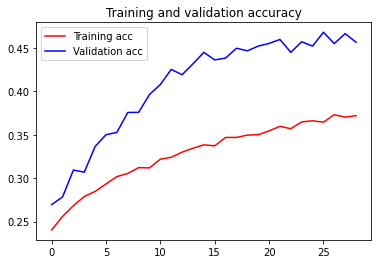

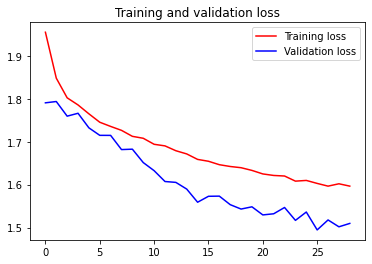

In [ ]:
fine_acc = fine_history.history['accuracy']
fine_val_acc = fine_history.history['val_accuracy']
fine_loss = fine_history.history['loss']
fine_val_loss = fine_history.history['val_loss']

epochs = range(len(fine_acc))

plt.plot(epochs, fine_acc, 'r', label='Training acc')
plt.plot(epochs, fine_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, fine_loss, 'r', label='Training loss')
plt.plot(epochs, fine_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




In [ ]:
# evaluate the model on the test set with evaluate() ...
model = tf.keras.models.load_model('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_augumented.h5')
test_loss, test_accuracy = model.evaluate(testing_dataset)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

113/113 [==============================] - 8s 61ms/step - loss: 1.5467 - accuracy: 0.3931
Test loss 1.5467036962509155
Test accuracy 0.39314571022987366
